# TP 3 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [4]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *

In [5]:
from functions import *

In [6]:
%load_ext autoreload
%autoreload 2

***

![ej1](img/consigna_1.png)

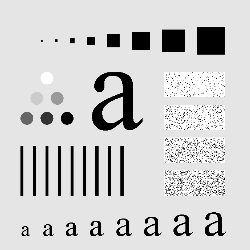

In [7]:
a = cv2.imread('img/a.tif', cv2.IMREAD_GRAYSCALE)
w, h = (500, 500)
a = cv2.resize(a, (w, h), cv2.INTER_NEAREST)
displayImage_fromcv2(a, w//2, h//2)

Aplicando los kernels de tamaño $n\times n$ del tipo
\begin{equation}
    w = \frac{1}{n^2}
    \begin{bmatrix}
    1 & 1 & ... & 1 \\
    1 & 1 & ... & 1 \\
    . & . & ... & . \\
    . & . & ... & . \\
    1 & 1 & ... & 1
    \end{bmatrix}
\end{equation}

Esto efectivamente realiza un promedio no ponderado de los pixeles dentro de una ventana, generando un efecto de 'blur'

In [8]:
window_sizes = [3,5,9,15,25,35,45,55]
a_comparison = a.copy()
for n in window_sizes:
    filtered_image = lowpass_unit_kernel(img=a, n=n)
    a_comparison = np.concatenate((a_comparison, filtered_image), axis=1)


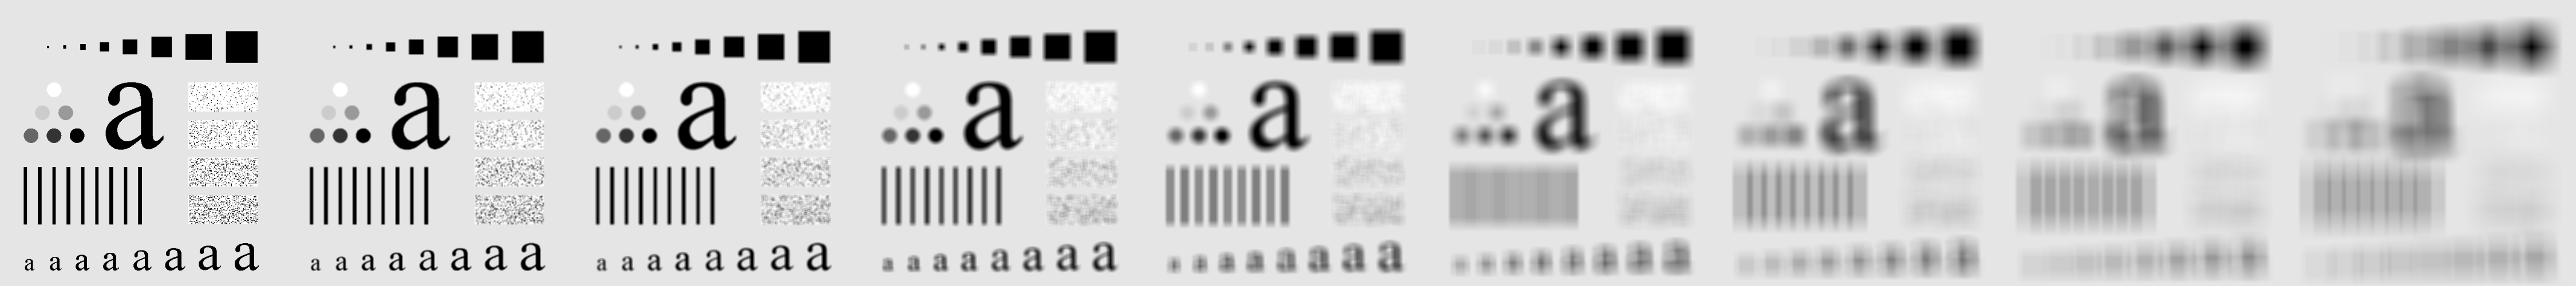

In [9]:
disp_img = Image.fromarray(a_comparison)
w, h = disp_img.size
displayImage(disp_img, w, h)

Los cuadrados negros en la parte superior van desapareciendo, a medida que el promedio del cual forman parte incluye cada vez más pixeles claros. Este efecto es más pronunciado en los bordes, donde se toman más puntos fuera del cuadrado.

A partir de cierto punto, las letras pierden su legibilidad por la pérdida de definición. Los círculos se vuelven cada vez menos visibles, empezando por los más claros ya que su promedio con el fondo se normaliza más rápidamente.

Las barras verticales se ven más mezcladas cuando el tamaño de la ventana es de $25\times25$, lo cual coincide con su ancho (5) más su separación (20).

El filtro no es particularmente bueno eliminando el ruido de los bloques en la derecha. En el ejercicio 3 se ve cómo usar la mediana es mejor para este tipo de ruido.

***

![ej2](img/consigna_2.png)

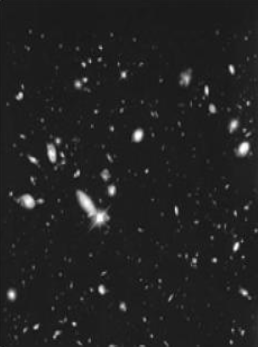

In [10]:
stars = cv2.imread('img/stars.png', cv2.IMREAD_GRAYSCALE)
h, w = stars.shape
displayImage_fromcv2(stars, w//3, h//3)

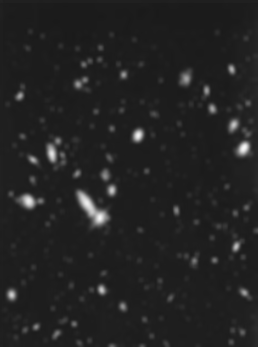

In [11]:
stars_filtered = lowpass_unit_kernel(img=stars, n=15)
displayImage_fromcv2(stars_filtered, w//3, h//3)

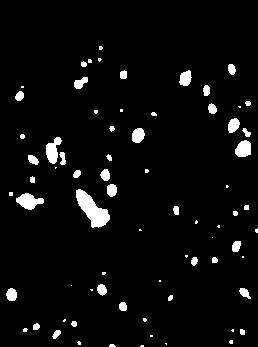

In [12]:
threshold = 0.25*np.max(stars_filtered)
stars_threshold = binary_mask(img=stars_filtered, threshold=threshold)
displayImage_fromcv2(stars_threshold, w//3, h//3)

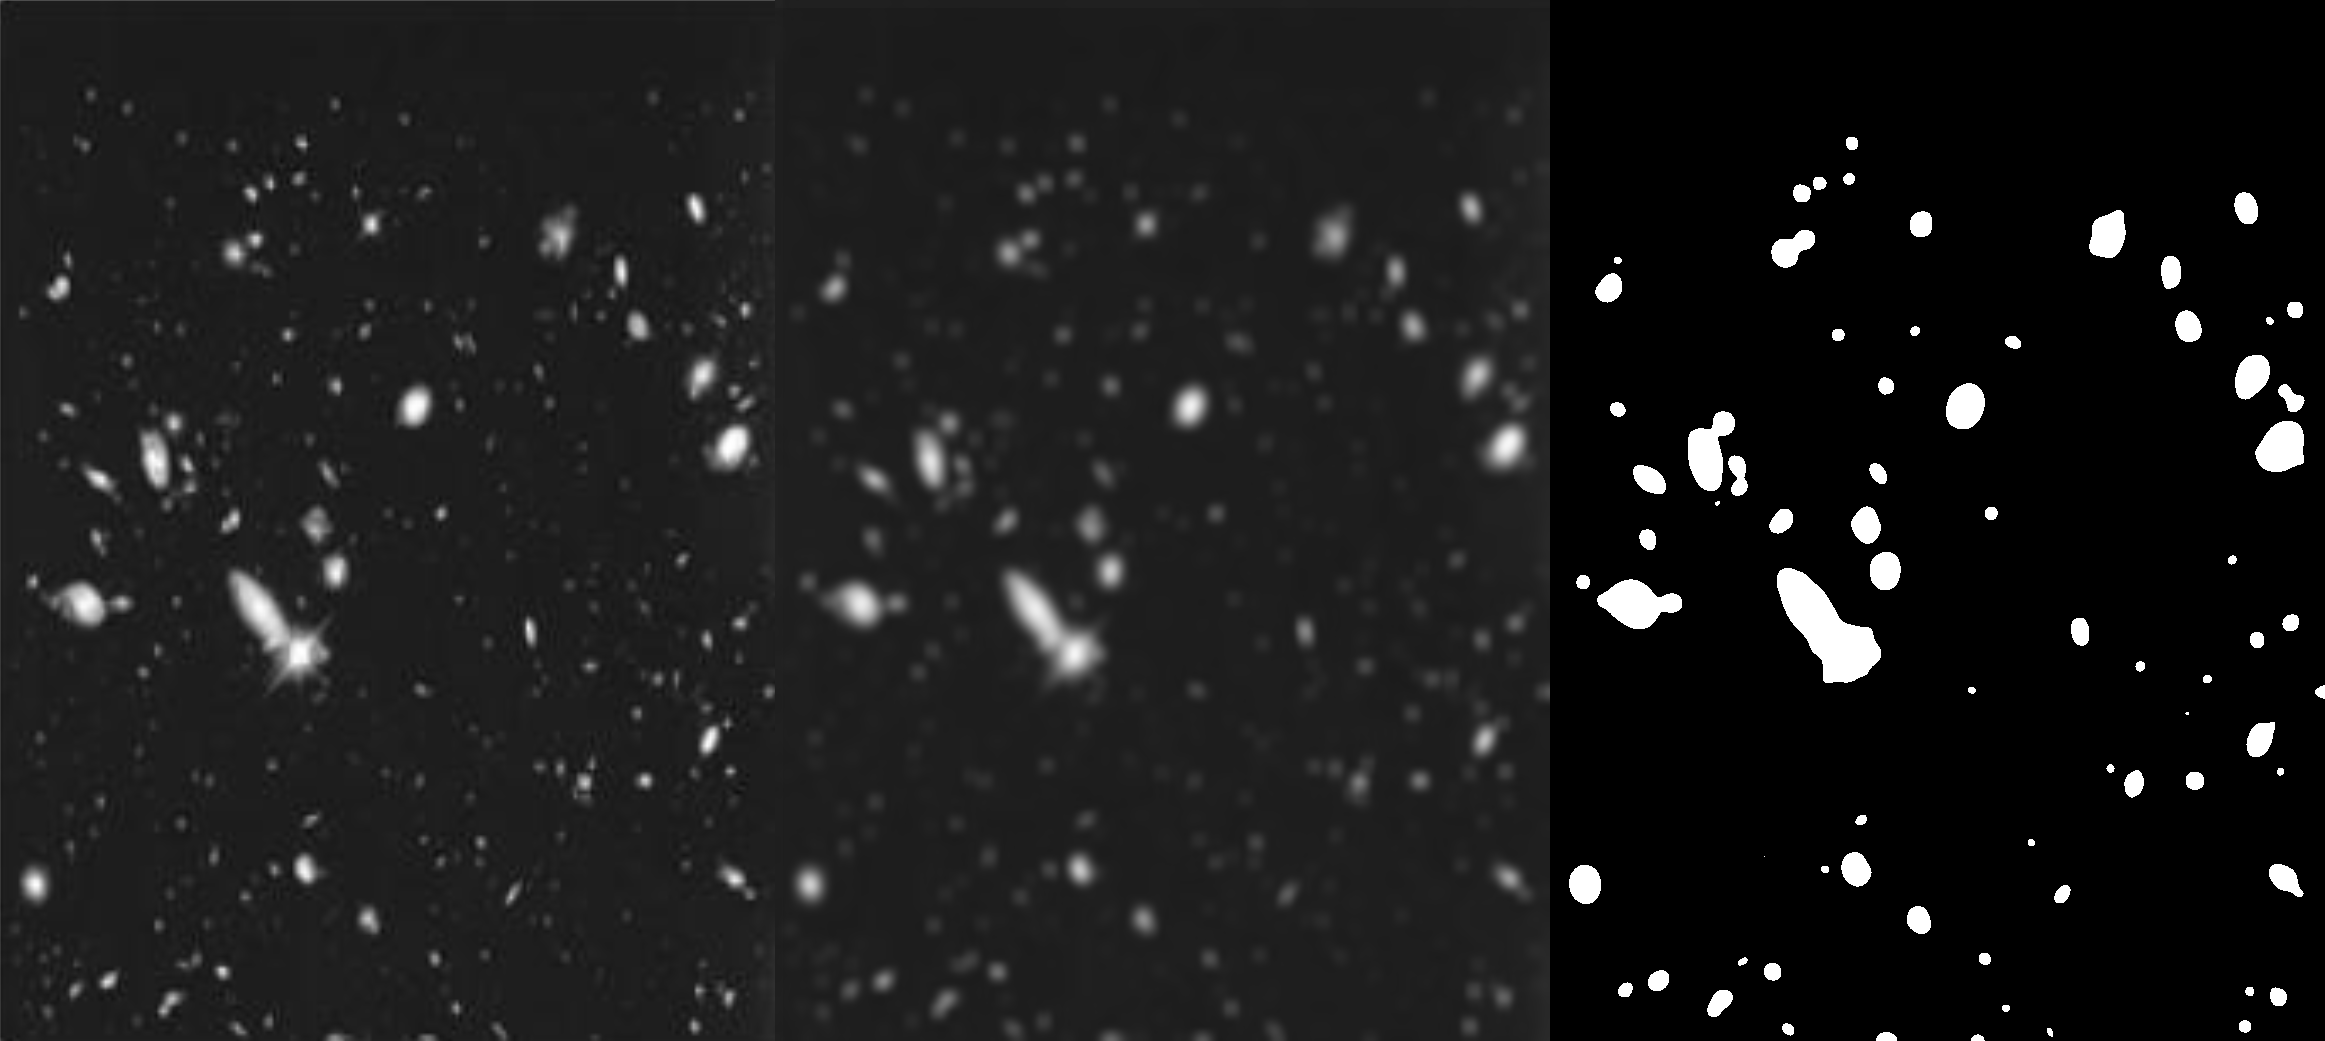

In [13]:
stars_comparison = np.concatenate((stars, stars_filtered, stars_threshold), axis=1)
displayImage_fromcv2(stars_comparison, w*3, h)

Se puede ver entonces que se pueden detectar los objetos mas grandes de la imágen, con un filtro para filtrar los objetos más pequeños y un threshold para aumentar el contraste.

***

![ej3](img/consigna_3.png)

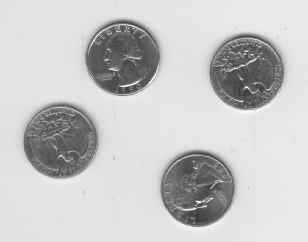

In [14]:
coins = cv2.imread('img/eight.tif', cv2.IMREAD_GRAYSCALE)
h, w = coins.shape
displayImage_fromcv2(coins, w, h)

Agregamos ruido "Salt & Pepper"

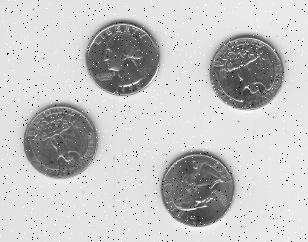

In [15]:
coins_sp = salt_and_pepper_noise(img=coins, d=0.02)
h, w = coins_sp.shape
displayImage_fromcv2(coins_sp, w, h)

Filtrado con pasa bajos

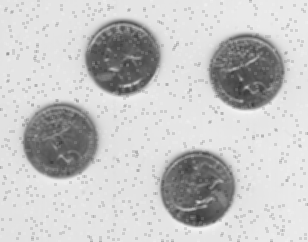

In [16]:
coins_filtered_lp = lowpass_unit_kernel(img=coins_sp, n=3)
displayImage_fromcv2(coins_filtered_lp, w, h)

Aplicando un filtro de mediana a la imagen con ruido sin LP

El filtro de mediana toma la ventana de vecinos de cada pixel, ordena su valor de gris de menor a mayor, y reemplaza el valor del pixel por el valor central del arreglo (si tiene una cantidad impar de elementos), o el promedio de los dos valores centrales (si tiene una cantidad par).

Esto efectivamente elimina los pixeles con valores "outliers" generados por el Salt and Pepper, ya que la probabilidad de que 0 o 255 sean elegidos como el nuevo valor de gris es prácticamente nula.

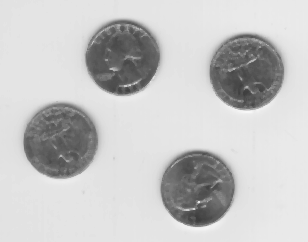

In [17]:
coins_filtered_median = cv2.medianBlur(coins_sp, 3)
displayImage_fromcv2(coins_filtered_median, w, h)

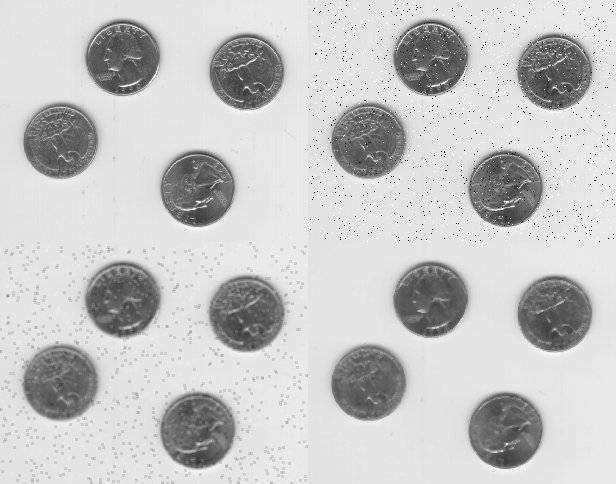

In [18]:
coins_comparison_h = np.concatenate((coins, coins_sp), axis=1)
coins_comparison_l = np.concatenate((coins_filtered_lp, coins_filtered_median), axis=1)
coins_comparison = np.concatenate((coins_comparison_h, coins_comparison_l))
displayImage_fromcv2(coins_comparison, w*2, h*2)

***

### 4. Uso del laplaciano para la recuperación del fondo sin perder la información de los bordes

Comentario: pude replicar el resultado con el kernel directo, pero todavía no con los pasos intermedios.

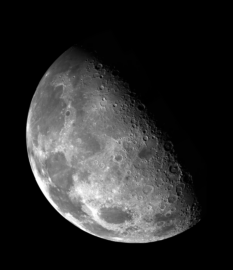

In [19]:
moon = cv2.imread('img/blurry_moon.tif', cv2.IMREAD_GRAYSCALE)
h, w = moon.shape
displayImage_fromcv2(moon, w//2, h//2)

Obteniendo el laplaciano, incluyendo diagonales con un kernel del tipo
\begin{equation}
    w = 
    \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & 8 & -1 \\
    -1 & -1 & -1 
    \end{bmatrix}
\end{equation}

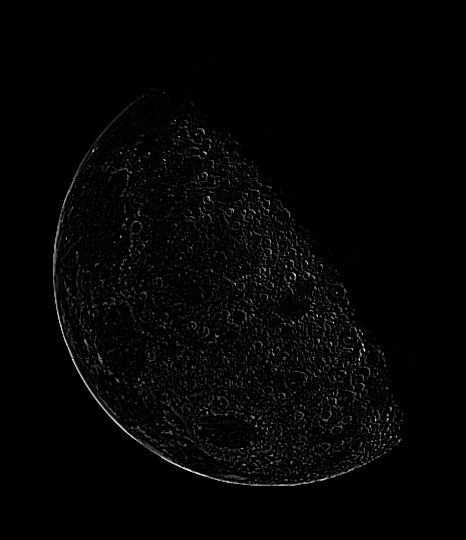

In [20]:
n = 3
kernel = np.ones((n,n))*(-1)
kernel[n//2,n//2] = 8
moon_laplacian = filter2D(src=moon, ddepth=-1, kernel=kernel)
displayImage_fromcv2(moon_laplacian, w, h)

In [21]:
# moon_laplacian -= np.amin(moon_laplacian)
# moon_laplacian_scaled = moon_laplacian*255.0/np.amax(moon_laplacian)
# displayImage_fromcv2(moon_laplacian_scaled,w,h)

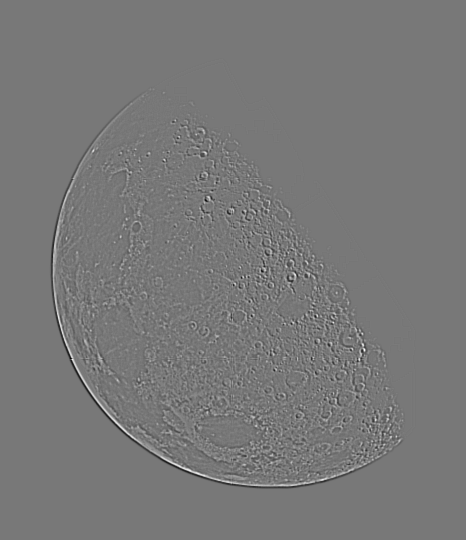

In [22]:
moon_f = (moon - np.amin(moon))*255.0/np.amax(moon)
moon_laplacian = filter2D(src=moon_f,ddepth=-1,kernel=kernel)
moon_laplacian_scaled = cv2.normalize(moon_laplacian, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
displayImage_fromcv2(moon_laplacian_scaled,w,h)

Sumando laplaciano y fondo con un kernel del tipo en la imagen original
\begin{equation}
    w = 
    \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & 9 & -1 \\
    -1 & -1 & -1 
    \end{bmatrix}
\end{equation}

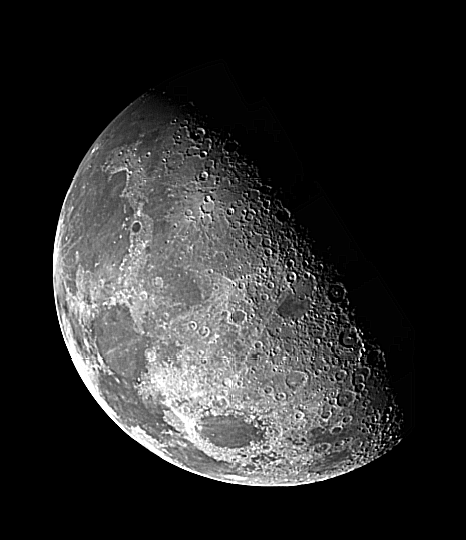

In [23]:
n = 3
kernel = np.ones((n,n))*(-1)
kernel[n//2,n//2] = 9
moon_filtered = filter2D(src=moon, ddepth=-1, kernel=kernel)
displayImage_fromcv2(moon_filtered, w, h)

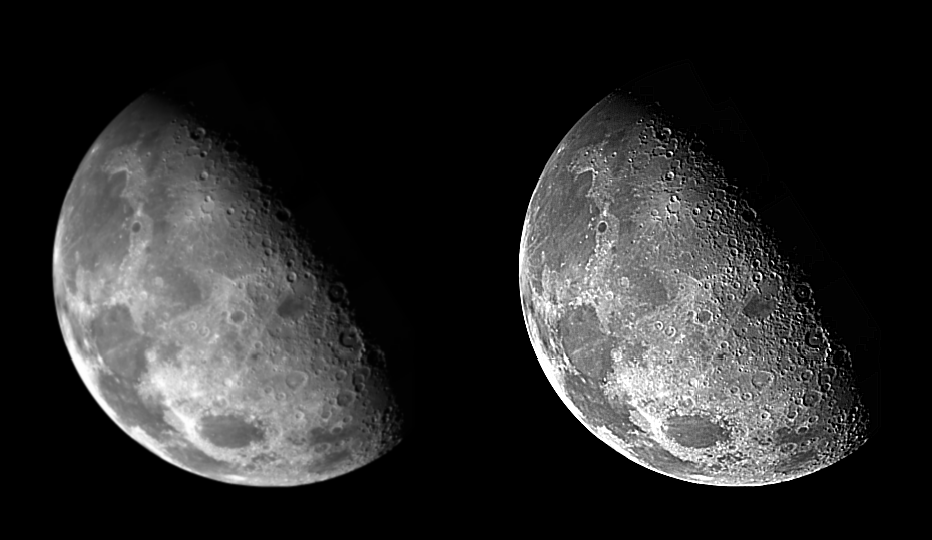

In [24]:
moon_comparison = np.concatenate((moon, moon_filtered), axis=1)
displayImage_fromcv2(moon_comparison, w*2, h)

***

### 5. High Boost

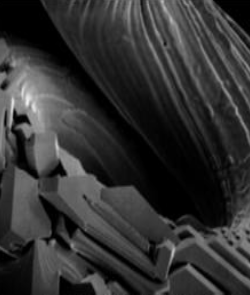

In [25]:
image_dark = cv2.imread('img/dark_img.png', cv2.IMREAD_GRAYSCALE)
h, w = image_dark.shape
displayImage_fromcv2(image_dark, w, h)

Aplicando el High Boost se usa el siguiente kernel
\begin{equation}
    w = 
    \begin{bmatrix}
    -1 & -1 & -1 \\
    -1 & A+8 & -1 \\
    -1 & -1 & -1 
    \end{bmatrix}
\end{equation}

Original:			A: 0				A: 1				A: 1.7				A: 2.2				

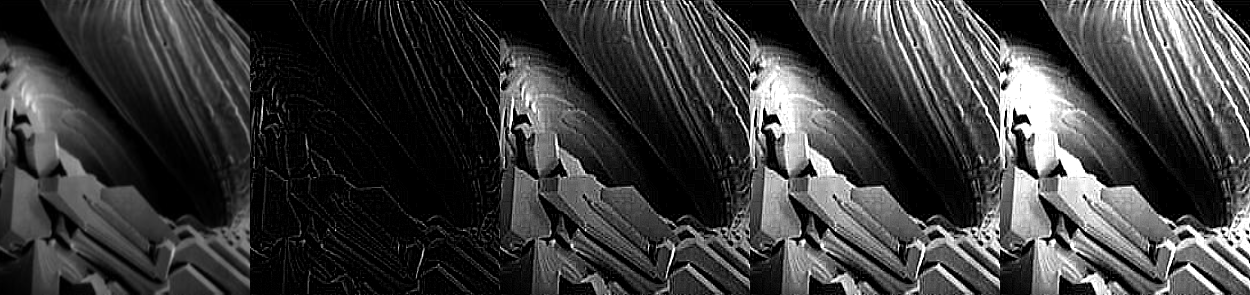

In [26]:
HB_comparison = image_dark
print("Original:",end='\t\t\t')
for A in [0,1,1.7,2.2]:
    HB_comparison = np.concatenate((HB_comparison, HB_Filter(A=A,img=image_dark)), axis=1)
    print("A:",A,end='\t\t\t\t')
disp_img = Image.fromarray(HB_comparison)
w, h = disp_img.size
displayImage(disp_img, w, h)

Se puede apreciar en los distintos resultados que al convolucionar la imagen original con un kernel con A>1 las componentes de alta frecuencia de la imagen se acentuan, mostrando la imagen mas clara y definida.<br>
Si bien esto sirve como mejora, un A mucho mas grande provoca que se sature tambien

***

![ej6](img/consigna_6.png)

### 6. Filtrado en el dominio de la frecuencia (Filtro Homomorfico)
Una imagen ($f(x,y)$) se puede pensar como el producto de dos imagenes, una que tiene componentes de baja frecuencia que nos informan del brillo, y otra que tiene las componentes de alta frecuencia que nos informan del contraste.

$f(x,y)\;=\;i(x,y)\;\cdot\;r(x,y)$

La componente $i(x,y)$ nos describe la iluminación de la imagen y contiene las componentes de baja frecuencia, y $r(x,y)$ describe las reflexiones internas de la imagen, compuesta por altas frecuencias.

El filtro homomorfico busca tanto normalizar el brillo como aumentar el contraste, lo cual se puede hacer a través de la aplicación de un filtro pasa-altos a $i(x,y)$ y $r(x,y)$. Pero, dado que estas dos se estan multiplicando, se simplifica el calculo aplicando el logaritmo natural, transformando el producto en una suma.

$m(x,y)\;=\;ln(f(x,y))\;=\;ln(i(x,y))\;\cdot\;ln(r(x,y))$

Luego, se realiza la DFT de la imagen, a la cual se aplica un filtro pasa-altos en el dominio de la frecuencia.

$M(u,v)\;=\;DFT[n(x,y)]$

$N(u,v)\;=\;H(u,v)\cdot M(u,v)$

Finalmente, se obtiene la imagen resultante ($g(x,y)$) realizando la IDFT y aplicando la función exponencial a la imagen.

$n(x,y)\;=\;IDFT[N(u,v)]$

$g(x,y)\;=\;e^{n(x,y)}$

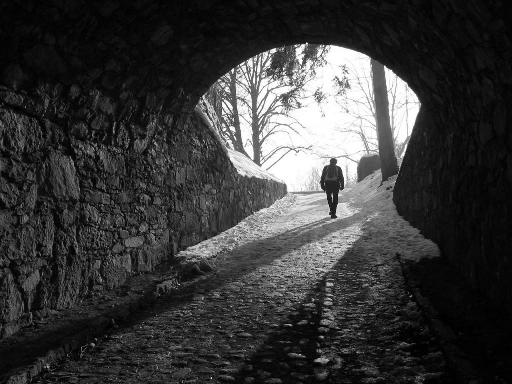

In [27]:
tun = cv2.imread('img/tun.jpg', cv2.IMREAD_GRAYSCALE)
h, w = tun.shape
displayImage_fromcv2(tun, w//2, h//2)

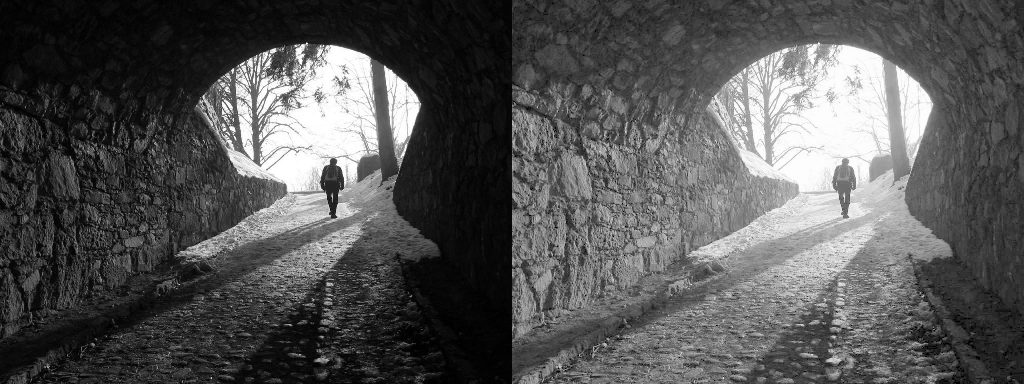

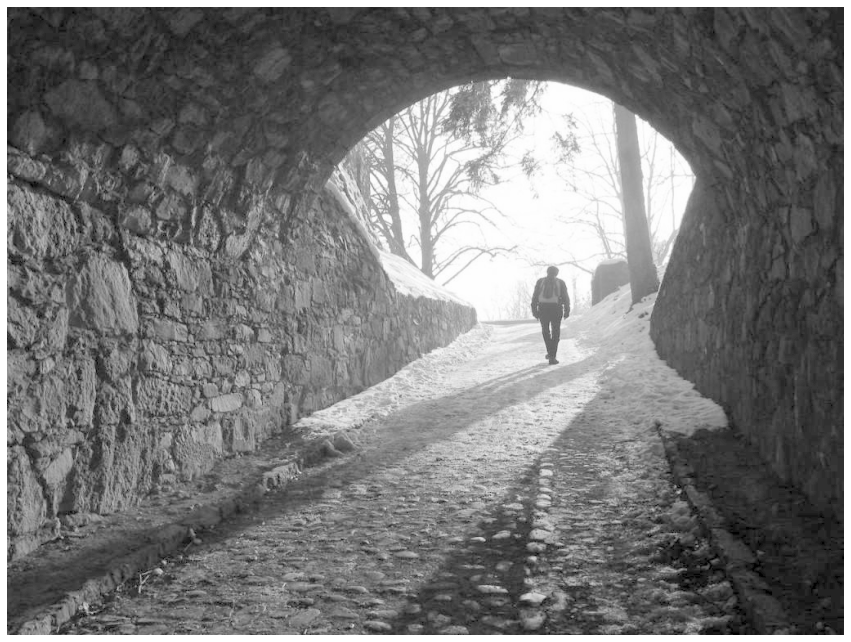

In [28]:
filtered_tun = homomorphic_filter(tun)

tun_comparison = np.concatenate((tun, filtered_tun), axis=1)
displayImage_fromcv2(tun_comparison, w, h//2)